In [27]:
!pip install ftfy regex tqdm
!pip install captum

In [28]:
import os
import torch
import CLIP.clip as clip
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from captum.attr import visualization
from CLIP.clip.simple_tokenizer import SimpleTokenizer as _Tokenizer


_tokenizer = _Tokenizer()

In [29]:
#@title Control context expansion (number of attention layers to consider)
#@title Number of layers for image Transformer
start_layer =  -1#@param {type:"number"}

#@title Number of layers for text Transformer
start_layer_text =  -1#@param {type:"number"}

In [30]:
def interpret(image, texts, model, device, start_layer=start_layer, start_layer_text=start_layer_text):
    batch_size = texts.shape[0]

    # repeat image batch_size times to match the text input batch_size
    images = image.repeat(batch_size, 1, 1, 1)

    # get logits for image and text
    logits_per_image, logits_per_text = model(images, texts)

    # compute softmax probability
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()

    # create an index list for batch processing
    index = [i for i in range(batch_size)]

    # create a one-hot encoding for gradient computation
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot * logits_per_image)

    model.zero_grad()

    # extract attention layers from the visual transformer
    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())

    # if start_layer = -1, set it to the last layer of the transformer
    if start_layer == -1:
      # calculate index of last layer
      start_layer = len(image_attn_blocks) - 1

    # get the number of tokens in the attention map
    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]

    # initialize the relevance matrix as an identity matrix
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)

    # compute relevance propagation through the layers
    for i, blk in enumerate(image_attn_blocks):
        if i < start_layer:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R = R + torch.bmm(cam, R)

    # extract relevance scores for the image
    image_relevance = R[:, 0, 1:]

    # extract attention layers from the text transformer
    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())

    if start_layer_text == -1:
      # calculate index of last layer
      start_layer_text = len(text_attn_blocks) - 1

    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]
    R_text = torch.eye(num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(text_attn_blocks):
        if i < start_layer_text:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R_text = R_text + torch.bmm(cam, R_text)

    # extract relevance score for the text
    text_relevance = R_text

    return text_relevance, image_relevance


def show_image_relevance(image_relevance, image, orig_image):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(orig_image);
    axs[0].axis('off');

    # resize image relevance scores to match image dimensions
    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cpu().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())

    # normalize the input image
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())

    # generate visualization
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    axs[1].imshow(vis);
    axs[1].axis('off');

def show_heatmap_on_text(text, text_encoding, R_text):
  CLS_idx = text_encoding.argmax(dim=-1)  # get CLS token index
  R_text = R_text[CLS_idx, 1:CLS_idx]  # extract relevance scores
  text_scores = R_text / R_text.sum()  # normalize relevance scores
  text_scores = text_scores.flatten()
  print(text_scores)

  # decode tokens back to text
  text_tokens=_tokenizer.encode(text)
  text_tokens_decoded=[_tokenizer.decode([a]) for a in text_tokens]

  # create visualization record and display
  vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,text_tokens_decoded,1)]
  visualization.visualize_text(vis_data_records)

In [31]:
device = "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

In [32]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'


In [33]:
image_dir = "data/controlled_images/"
test_case = {
        "image_id": "2402809",
        "obj1_name": "apple",
        "obj2_name": "armchair",
        "bbox_x": 92,
        "bbox_y": 17,
        "bbox_w": 271,
        "bbox_h": 314,
        "true_caption": "A apple to the left of a armchair",
        "false_caption": [ "A apple on a armchair", "A apple under a armchair", "A apple to the right of a armchair"],
        "attributes": [
        ],
        "image_path": "book_under_armchair.jpeg"
    }

In [34]:
img_path = image_dir + test_case["image_path"]
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

text:  a book under an armchair
tensor([6.4150e-03, 5.8692e-03, 2.2654e-03, 4.8947e-04, 9.8496e-01])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a book under an armchair


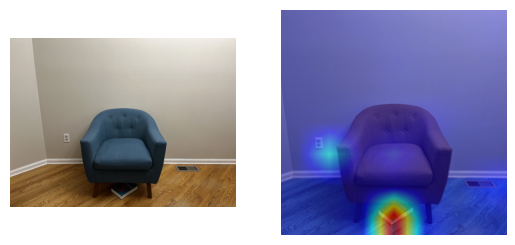

In [35]:
img_path = image_dir + test_case["image_path"]
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["a book under an armchair"]
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device="cpu")
batch_size = text.shape[0]
for i in range(batch_size):
  print("text: ", texts[i])
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

text:  an armchair
tensor([0.0308, 0.9692])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,an armchair


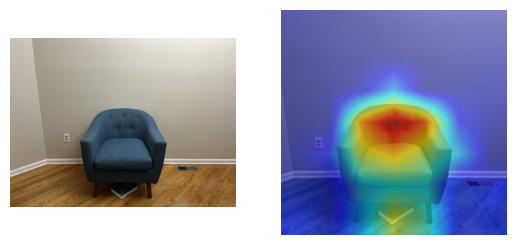

In [36]:
img_path = image_dir + test_case["image_path"]
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["an armchair"]
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device="cpu")
batch_size = text.shape[0]
for i in range(batch_size):
  print("text: ", texts[i])
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

# load negclip

In [37]:
device = "cpu"

In [38]:
model_path = "/Users/itazaporozhets/VSCode/whatsup_vlms/notebooks/~/.cache/negclip.pth"
model, preprocess = clip.load(model_path, device=device, jit=False)


text:  a book under an armchair
tensor([1.6583e-03, 2.5230e-03, 2.7727e-03, 6.0584e-05, 9.9299e-01])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a book under an armchair


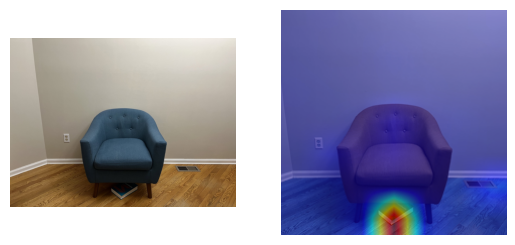

In [39]:
img_path = image_dir + test_case["image_path"]
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["a book under an armchair"]
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device="cpu")
batch_size = text.shape[0]
for i in range(batch_size):
  print("text: ", texts[i])
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()